# CP2 Radar Tutorial

## Introduction

<img align="right" width="400" height="800" src="img/cp2.jpg" border="5">

The Redbank Plains (Brisbane) CP2 radar was configured with various scanning strageties during its operations which were dependent on the research requirements.

These include:
1. volumes (what we get from operational radars)
2. vertical cross sections (RHI's)
3. bird bath scans (for calibration)
4. sector scans

The radar had two antenna systems. An X-band antenna that collected some polarimetric measurements and an S band antenna that collected full polarimetric measurements. Given the scattering and attenuation of radiation by precipitation is dependent on the frequency, the dual frequency dataset provides an additonal information for investigation. CP-2 was sited in proximity to the operational Mt Stapylton weather radar. The Doppler information from these radars can be used to retrieve the 3D wind field (where there's signal) over the Brisbane City region and Gold Coast hinterland.

The CP2 dataset also includes derived measurements, which include hydrometeor classification.
All level 1 CP2 files use the Radial MDV format (NCAR), which is described [here](https://www.eol.ucar.edu/system/files/MDV_format_ICD.pdf)

Before arriving in Australia, the CP2 radar had a long history and has contributed to many major discoveries.
The system was first built in the 1970’s for hail and precipitation research as part of the US National Hail Research Experiment (NHRE) and contributed to dozens of major field projects internationally (including Ted Fujita's work on microbursts).

For this tutorial we'll look at the different scanning strageties, bands and derived measurements

<img align="left" width="400" height="800" src="img/cp2-map.jpg" border="5">



In [11]:
"""
#############################################################
#
# For this tutorial we will use the 27 November 2014 hailstorm event (occuring around 05-07 Z, 15-17 LST).
# Let's define the files we will use
#
#############################################################
"""


import warnings
warnings.simplefilter("ignore")

#for volumes, let's use the 05:53 Z scan
vol_sband_url = 'https://dapds00.nci.org.au/thredds/fileServer/hj10/cp2/level_1/s_band/sur/2014/20141127/cp2-s_20141127_055303.sur.mdv'
vol_xband_url = 'https://dapds00.nci.org.au/thredds/fileServer/hj10/cp2/level_1/x_band/sur/2014/20141127/cp2-x_20141127_055303.sur.mdv'
vol_derived_url = 'https://dapds00.nci.org.au/thredds/fileServer/hj10/cp2/level_1/derived/sur/2014/20141127/cp2-derived_20141127_055303.sur.mdv'


/home/meso/miniconda3/envs/radar-dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
"""
#############################################################
#
# Download these volumes from NCI
#
#############################################################
"""

import urllib

vol_sband_ffn = '/tmp/cp2-s_20141127.sur.mdv'
urllib.request.urlretrieve(vol_sband_url, vol_sband_ffn)
vol_xband_ffn = '/tmp/cp2-x_20141127.sur.mdv'
urllib.request.urlretrieve(vol_xband_url, vol_xband_ffn)
vol_derived_ffn = '/tmp/cp2-derived_20141127.sur.mdv'
urllib.request.urlretrieve(vol_derived_url, vol_derived_ffn)

print('All files downloaded')

All files downloaded


In [61]:
"""
#############################################################
#
# Open volumes using PyART and print fields
#
#############################################################
"""

import pyart

vol_sband = pyart.io.read_mdv(vol_sband_ffn, file_field_names=True)
print('S band fields:', vol_sband.fields.keys())

vol_xband = pyart.io.read_mdv(vol_xband_ffn, file_field_names=True)
print('X band fields:', vol_xband.fields.keys())

vol_derived = pyart.io.read_mdv(vol_derived_ffn, file_field_names=True)
print('Derived fields:', vol_derived.fields.keys())

"""
#############################################################
#
# Fields which we'll be using for the tutorial
#
# DBZ: Reflectivity
# VEL: Doppler Velocity
# ZDR: Differential Reflectivity
# PID: Particle Identification
#
#############################################################
"""

S band fields: dict_keys(['NCP', 'VEL_F', 'ZDRM_F', 'RHOHV_F', 'KDP_F', 'ZDRM', 'CLUT', 'CMD', 'RHOHV', 'CMD_FLAG', 'SPECTRAL_SNR', 'DBMHC', 'ZDR', 'VEL', 'PHIDP_F', 'DBZ_F', 'ZDR_F', 'WIDTH_F', 'KDP', 'DBMVC', 'DBZ', 'SNR_F', 'WIDTH', 'CPA', 'DBMVC_F', 'DBMHC_F', 'SNR', 'CLUT_2_WX_RATIO', 'PHIDP'])
X band fields: dict_keys(['LDRV', 'LDRH', 'DBM', 'DBZ', 'SNR'])
Derived fields: dict_keys(['RATE_KDP_ZDR', 'RATE_KDP', 'PidInterest2', 'PidInterest', 'RATE_Z_ZDR', 'KDP', 'RATE_HYBRID', 'ZDR_FOR_PID', 'RATE_ZH', 'TEMP_FOR_PID', 'PID', 'PID2'])


"\n#############################################################\n#\n# Fields which we'll be using for the tutorial\n#\n# DBZ: Reflectivity\n# VEL: Doppler Velocity\n# ZDR: Differential Reflectivity\n# PID: Particle Identification\n#\n#############################################################\n"

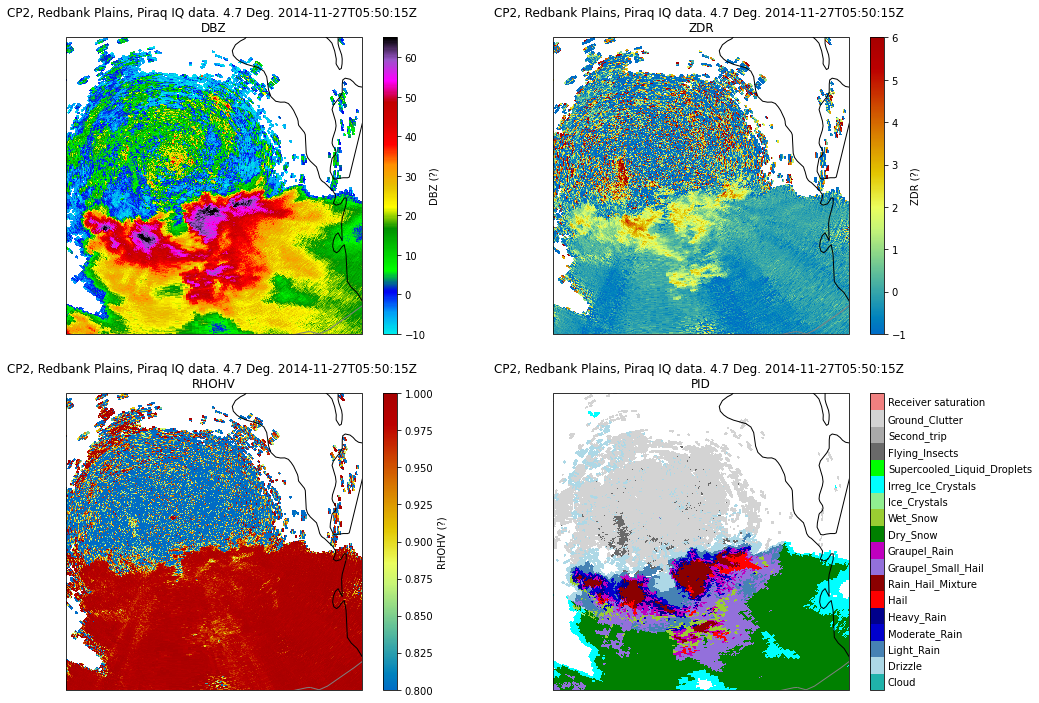

In [117]:
"""
#############################################################
#
# Let's create a PPI plots of some fields and discuss what we can see.
#
#############################################################
"""

from matplotlib import pyplot as plt #plotting toolkit
import numpy as np
import cartopy.crs as ccrs
import matplotlib.colors as colors

#create colormap for PID
ncar_colors = ['lightseagreen',
               'LightBlue', 'SteelBlue', 'MediumBlue', 'DarkBlue',
      'Red','DarkRed',
      'MediumPurple','m',
      'Green','YellowGreen','lightgreen','cyan','lime',
      'dimgray','darkgray','lightgray','lightcoral']

ncar_cmap = colors.ListedColormap(ncar_colors)

#create function for PID labels
def _adjust_ncar_scheme_colorbar_for_pyart(cb):
    cb.set_ticks(np.arange(1.5, 19.5, 1))
    cb.ax.set_yticklabels(['Cloud',
                           'Drizzle', 'Light_Rain', 'Moderate_Rain', 'Heavy_Rain',
                            'Hail', 'Rain_Hail_Mixture',
                            'Graupel_Small_Hail', 'Graupel_Rain',
                            'Dry_Snow', 'Wet_Snow', 'Ice_Crystals', 'Irreg_Ice_Crystals', 'Supercooled_Liquid_Droplets',
                            'Flying_Insects', 'Second_trip', 'Ground_Clutter', 'Receiver saturation'])
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb

fig = plt.figure(figsize=(16, 12), facecolor='w')

tilt = 4

ax = plt.subplot(221, projection=ccrs.PlateCarree())
vol_sband_disp = pyart.graph.RadarMapDisplay(vol_sband)
vol_sband_disp.plot_ppi_map('DBZ', tilt,
                            cmap='pyart_NWSRef',
                            min_lat=-28.25, max_lat=-27.25, min_lon=152.5, max_lon=153.5,
                            vmin=-10, vmax=65,
                            resolution='10m')

ax = plt.subplot(222, projection=ccrs.PlateCarree())
vol_sband_disp.plot_ppi_map('ZDR', tilt,
                            cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                            min_lat=-28.25, max_lat=-27.25, min_lon=152.5, max_lon=153.5,
                            vmin=-1, vmax=6,
                            resolution='10m')

ax = plt.subplot(223, projection=ccrs.PlateCarree())
vol_sband_disp.plot_ppi_map('RHOHV', tilt,
                            cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                            min_lat=-28.25, max_lat=-27.25, min_lon=152.5, max_lon=153.5,
                            vmin=0.8, vmax=1.0,
                            resolution='10m')

ax = plt.subplot(224, projection=ccrs.PlateCarree())
vol_derived_disp = pyart.graph.RadarMapDisplay(vol_derived)
vol_derived_disp.plot_ppi_map('PID', tilt,
                            cmap=ncar_cmap,
                            min_lat=-28.25, max_lat=-27.25, min_lon=152.5, max_lon=153.5,
                            vmin=1, vmax=19,
                            resolution='10m')
_adjust_ncar_scheme_colorbar_for_pyart(vol_derived_disp.cbs[0])

# to do: fix PID labels
# repeats with RHI and compare with theortical cross section
# showcase some 3D wind retrieval and the packages used for this

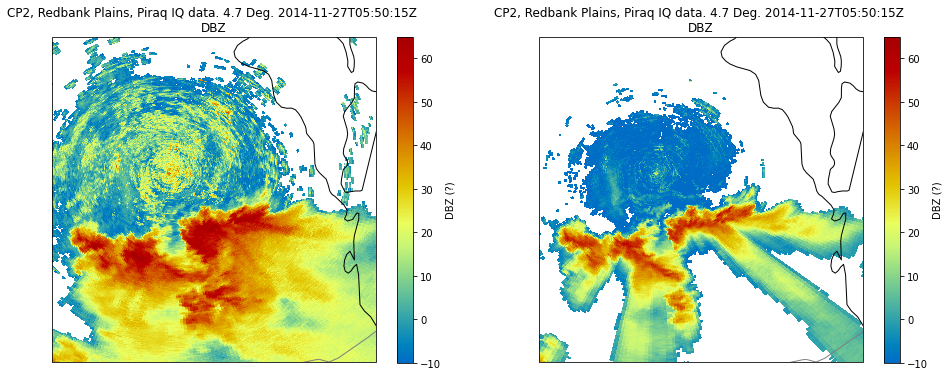

In [112]:
"""
#############################################################
# 
# Now let's compare X and S band reflectivity measurements
#
#############################################################
"""

fig = plt.figure(figsize=(16, 6), facecolor='w')

ax = plt.subplot(121, projection=ccrs.PlateCarree())
vol_sband_disp.plot_ppi_map('DBZ', tilt,
                            cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                            min_lat=-28.25, max_lat=-27.25, min_lon=152.5, max_lon=153.5,
                            vmin=-10, vmax=65,
                            resolution='10m')

ax = plt.subplot(122, projection=ccrs.PlateCarree())
vol_xband_disp = pyart.graph.RadarMapDisplay(vol_xband)
vol_xband_disp.plot_ppi_map('DBZ', tilt,
                            cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                            min_lat=-28.25, max_lat=-27.25, min_lon=152.5, max_lon=153.5,
                            vmin=-10, vmax=65,
                            resolution='10m')

## Now let's look at plotting some RHI data

In [107]:
"""
#############################################################
#
# Define and download these RHI's from NCI
#
#############################################################
"""

rhi_sband_url = 'https://dapds00.nci.org.au/thredds/fileServer/hj10/cp2/level_1/s_band/rhi/2014/20141127/cp2-s_20141127_065402.rhi.mdv'
rhi_derived_url = 'https://dapds00.nci.org.au/thredds/fileServer/hj10/cp2/level_1/derived/rhi/2014/20141127/cp2-derived_20141127_065402.rhi.mdv'

rhi_sband_ffn = '/tmp/cp2-s_20141127.rhi.mdv'
urllib.request.urlretrieve(rhi_sband_url, rhi_sband_ffn)
rhi_derived_ffn = '/tmp/cp2-derived_20141127.rhi.mdv'
urllib.request.urlretrieve(rhi_derived_url, rhi_derived_ffn)


('/tmp/cp2-derived_20141127.rhi.mdv',
 <http.client.HTTPMessage at 0x7f8f812a7040>)

In [108]:
"""
#############################################################
#
# Read RHI files and print the azimuths
#
#############################################################
"""

rhi_sband = pyart.io.read_mdv(rhi_sband_ffn, file_field_names=True)
rhi_derived = pyart.io.read_mdv(rhi_derived_ffn, file_field_names=True)

azimuth_list = rhi_sband.fixed_angle['data']
print('azimuth list:', azimuth_list)

azimuth list: [20.15 29.96 40.01 49.97]


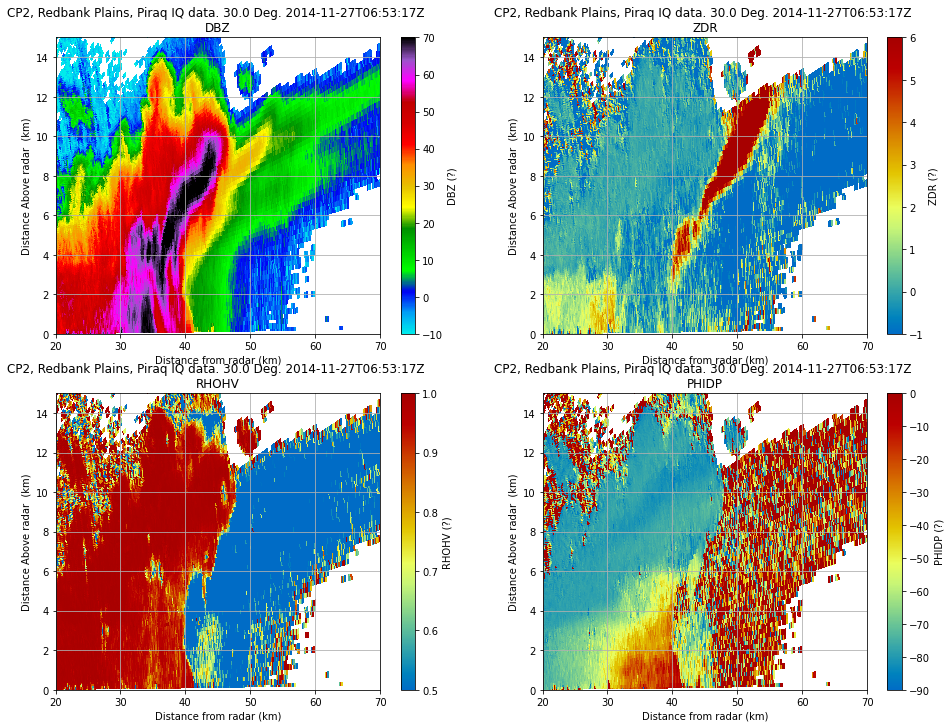

In [127]:
rhi_idx = 1

fig = plt.figure(figsize=(16, 12), facecolor='w')

ax = plt.subplot(221)
rhi_sband_disp = pyart.graph.RadarMapDisplay(rhi_sband)
rhi_sband_disp.plot('DBZ', rhi_idx,
                            cmap='pyart_NWSRef',
                            vmin=-10, vmax=70)
ax.set_xlim([20,70])
ax.set_ylim([0,15])
ax.grid()

ax = plt.subplot(222)
rhi_sband_disp.plot('ZDR', rhi_idx,
                            cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                            vmin=-1, vmax=6)
ax.set_xlim([20,70])
ax.set_ylim([0,15])
ax.grid()

ax = plt.subplot(223)
rhi_sband_disp.plot('RHOHV', rhi_idx,
                            cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                            vmin=0.5, vmax=1.0)
ax.set_xlim([20,70])
ax.set_ylim([0,15])
ax.grid()

ax = plt.subplot(224)
rhi_sband_disp.plot('PHIDP', rhi_idx,
                            cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                            vmin=-90, vmax=0)
ax.set_xlim([20,70])
ax.set_ylim([0,15])
ax.grid()



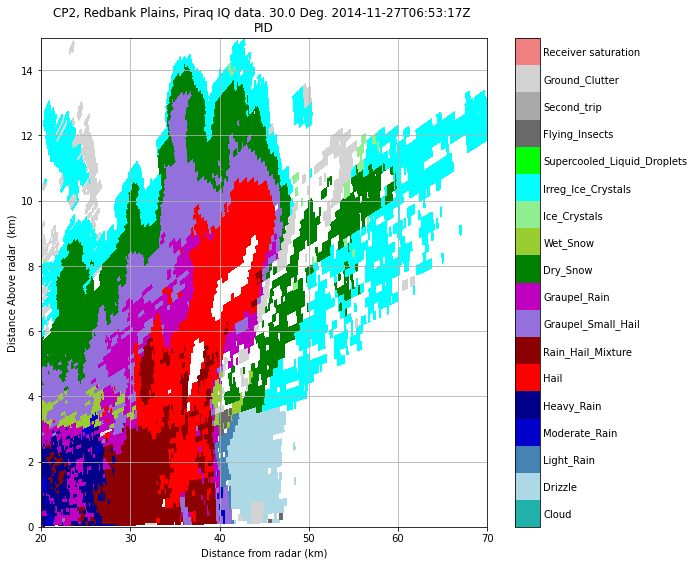

In [131]:
fig = plt.figure(figsize=(10, 9), facecolor='w')
ax = plt.subplot(111)
rhi_derived_disp = pyart.graph.RadarMapDisplay(rhi_derived)
rhi_derived_disp.plot('PID', rhi_idx,
                            cmap=ncar_cmap,
                            vmin=1, vmax=19)
ax.set_xlim([20,70])
ax.set_ylim([0,15])
ax.grid()
_adjust_ncar_scheme_colorbar_for_pyart(rhi_derived_disp.cbs[0])

### We can compare the hydrometeor distribution to what we expect for an idealised supercell.

<img align="left" width="600" height="400" src="img/supercell_conceptual_xsection.jpg" border="5">

## Next Steps

1. Removal of non-meteorological echoes
2. Correction of attenuation (especially for X band)
3. Correction of phase and differential reflectivity

For examples of these procedures, check out Valentin's (CPOL processing package)[https://github.com/vlouf/cpol_processing]

## And Beyond

Using the colocated Mt Stapylton radar it's also possible to retrieve the 3D wind field (u,v,w) for this event and many other events sampled by CP-2.

An open-source packages for retrieving 3D winds is [PyDDA](https://github.com/openradar/PyDDA), which is built on PyART!

Once retrieved, 3D wind information can be used to understand the kinematics of convective clouds, tropical cyclones (e.g., from CPOL), tornadic storms, sea breezes etc!

<img align="left" width="600" height="400" src="img/3Dwinds.gif" border="5">